### Human expert move predictor 01

This notebook demonstrates the training of a human expert move neural network predictor on the Othello game. The trained network will be used to bootstrap the AlphaZero network training.

__Notes__:
1. With enough computing resources, this bootstrap step is not absolutely necessary, i.e. the AlphaZero network can be trained from a random network. 
1. We skipped quite a few steps in generating a proper predictive model (e.g. train-test-validate, measurements of key indicators) as they are not essential in the bootstrapping task. We shall backfill them in the future

#### Data sources
* original tournament data are obtained from http://www.ffothello.org/informatique/la-base-wthor/
* encoded dataset used in this notebook can be downloaded at https://drive.google.com/open?id=1thIFevwYhD9Y9JIMvLPS6QF0TiIzNbKR

In [1]:
import sys
import time
import json
import numpy
import glob
import random
import copy
import dill
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import torch
import torch.nn
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#### NETWORK ARCHITECTURE
A simplistic one hidden layer neural network to learn experts' moves

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # define functionals
        self.fc1     = torch.nn.Linear(64, 100)
        self.norm1   = torch.nn.BatchNorm1d(100)
        self.relu1   = torch.nn.ReLU()
        self.fc2     = torch.nn.Linear(100, 62)
        self.softmax = torch.nn.Softmax()
        self.sigmoid = torch.nn.Sigmoid()
    # end def
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out_p, out_v = torch.split(out, (61, 1), 1)
        out_p = self.softmax(out_p)
        out_v = self.sigmoid(out_v)
        out = torch.cat((out_p, out_v), 1)
        return out
    # end def
# end class

#### Customized loss function
The loss function takes the same form of AlphaZero

In [6]:
def cal_err(outputs, labels):
    # get the batch size
    batch_n = outputs.shape[0]

    move_probs, pred_vals = torch.split(outputs, (61, 1), 1)
    search_probs, winners = torch.split(labels , (61, 1), 1)
    pred_vals = pred_vals*2 - 1 # transform range from [0, 1] to [-1, 1]
    
    # compute the loss function
    pi   = search_probs.contiguous().view(-1).float()
    logp = torch.log(move_probs).contiguous().view(-1).float()
    
    err_vals  = torch.pow(pred_vals - winners, 2).sum()
    err_probs = pi.dot(logp)
        
    loss = err_vals - err_probs
    loss = loss / batch_n
    return loss
# end def

class AlphaZERO_Loss(torch.nn.Module):        
    def forward(self, outputs, labels):
        loss = cal_err(outputs, labels)
        return loss
    # end def
# end class

##### Define connecting functions and variables for the network

In [ ]:
label2move = {0: [0, 0], 1: [0, 1], 2: [0, 2], 3: [0, 3], 4: [0, 4], 5: [0, 5], 6: [0, 6], 
              7: [0, 7], 8: [1, 0], 9: [1, 1], 10: [1, 2], 11: [1, 3], 12: [1, 4], 13: [1, 5], 
              14: [1, 6], 15: [1, 7], 16: [2, 0], 17: [2, 1], 18: [2, 2], 19: [2, 3], 20: [2, 4], 
              21: [2, 5], 22: [2, 6], 23: [2, 7], 24: [3, 0], 25: [3, 1], 26: [3, 2], 27: [3, 5], 
              28: [3, 6], 29: [3, 7], 30: [4, 0], 31: [4, 1], 32: [4, 2], 33: [4, 5], 34: [4, 6], 
              35: [4, 7], 36: [5, 0], 37: [5, 1], 38: [5, 2], 39: [5, 3], 40: [5, 4], 41: [5, 5], 
              42: [5, 6], 43: [5, 7], 44: [6, 0], 45: [6, 1], 46: [6, 2], 47: [6, 3], 48: [6, 4], 
              49: [6, 5], 50: [6, 6], 51: [6, 7], 52: [7, 0], 53: [7, 1], 54: [7, 2], 55: [7, 3], 
              56: [7, 4], 57: [7, 5], 58: [7, 6], 59: [7, 7], 60: 'PASS'}
move2label = {tuple(q): p for p, q in label2move.items()}

def outcome2array(Y):
    output = []
    for i in range(len(Y)):
        _move, _winner = Y[i]
        _move = tuple(_move)
        
        out = numpy.zeros(62)
        out[move2label[_move]] = 1
        out[-1] = _winner
        
        output.append(out)
    # end for
    return numpy.array(output)
# end def

##### Define functions to read training data

In [ ]:
def read_data_from_file(filename, shuffle=True):
    with open(filename) as fin:
        content = fin.read().splitlines()
    # end with
    
    # read only black's move
    # - note: if assume first and second movers should
    # have the same strategy, we could revert white's 
    # color and merge the data. It is not implemented here
    swap = []
    for i in range(len(content)):
        if (i % 2) == 0:
            swap.append(content[i])
        # end if
    # end for
    content = swap
    
    # shuffle the data
    if shuffle:
        random.shuffle(content)
    # end if

    X, Y = [[], []]
#    content = content[-10:] # read only last 20 moves
    for row in content:
        x, y = json.loads(row)
        X.append(x)
        Y.append(y)
    # end for

    # convert to numpy array
    X = numpy.array(X)
    Y = outcome2array(Y)

    return X, Y
# end def

def read_some_data(files, N=20):
    input_data = []
    
    ## GET INPUT DATA ##
    # select input files from directory randomly
    sel_files = [random.choice(files) for _ in range(N)]
    data = [read_data_from_file(_file) for _file in sel_files]
    X, Y = [[], []]
    for x, y in data:
        X.extend(x)
        Y.extend(y)
    # end for
    return X, Y
# end def

def chunks(l, n):
    output = []
    for i in range(0, len(l), n):
        sel = l[i:i+n]
        if len(sel) > 1: # bug(/feature?) of pytorch: do not accept length-one tensor
            output.append(sel)
        # end if
    # end for
    return output
# end def

#### Define a training epoch

In [ ]:
def epoch(files, BATCH_SIZE, n=1):
    net.train(True) # set to training mode
    stime = time.time()

    # read data
    X, Y = read_some_data(files=files)
    Xs = chunks(X, BATCH_SIZE)
    Ys = chunks(Y, BATCH_SIZE)

    logger.info(' - start training')
    for _iter in range(n):
        running_loss = 0
        for i in range(len(Xs)):
            inputs = torch.from_numpy(numpy.array(Xs[i])).float()
            labels = torch.from_numpy(numpy.array(Ys[i])).float()
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # gradient clipping ...
            torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
            running_loss += loss.item()
        # end for
        loss = running_loss / len(Xs)
        logger.info('[iteration %d] loss: %4.3f' % (_iter, loss))
    # end for
    return loss
# end def

#### Training parameters

In [8]:
LEARNING_RATE = 0.01
MOMENTUM      = 0.9
BATCH_SIZE    = 200
EPOCH_N       = 10

##### Input sources and output destinations

In [ ]:
indir  = 'data/labelled'
outdir = './data/models/'
logfilename = './result.log'

#### Initialize the network and optimizer

In [9]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion = AlphaZERO_Loss()

In [11]:
# upload net to device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

#### Start training

In [23]:
# list the training files 
files = glob.glob(indir+'/*.dat')

stime = time.time()
losses = []
for i in range(100000):
    loss = epoch(files, BATCH_SIZE)
    if loss is numpy.nan:
        logger.error('loss became nan')
        break
    # end if
    
    ###################
    # LOSS MONITORING #
    ###################
    net.train(False)
    if i % 200 == 0:
        losses.append(loss)
        with open(logfilename, 'a') as fout:
            msg = 'iteration: %d | loss: %4.3f | time: %4.1f' % (i, loss, time.time()-stime)
            fout.writelines(msg+'\n')
        # end with
    # end if

    ####################
    # MODEL VERSIONING #
    ####################
    if i % 500 == 0:
        name='oth_exp_pred-iter'+str(i).zfill(5)
        # save model
        outfile = outdir+'/'+name+'.dill'
        with open(outfile, 'wb') as fout:
            dill.dump(copy.deepcopy(net), fout)
        # end with
    # end if
# end for

/home/kuanpern/AlphaZeroOthello/dev/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


##### Plotting the loss function over training

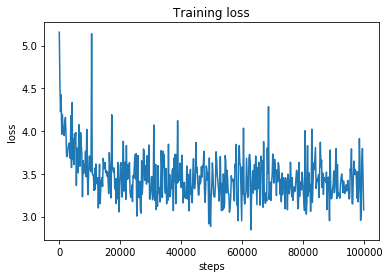

In [47]:
xs = numpy.arange(len(losses)) * 200
plt.plot(xs, losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Training loss');

### Sanity checks

Here we randomly picked a mid-game position and see how the network would respond.

In [24]:
_mid = [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, -1, 1, -1, 1, 
        -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 
        -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 
        1, 1, -1, -1, -1, -1, -1, 0, 1, 1, -1, -1, 
        -1, -1, -1, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0]
_mid = torch.from_numpy(numpy.array([_mid, _mid])).float()
_mid = _mid.to(device)

/home/kuanpern/AlphaZeroOthello/dev/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Winning probability estimate: 88.3 %
Pass probability:  0.5 %


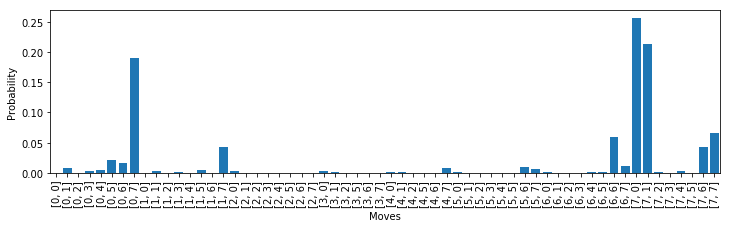

In [78]:
# Extract the numbers ..
output = net(_mid)[0].detach().cpu().numpy()
preds, vals  = output[:-1], output[-1]
moves, _pass = preds[:-1], preds[-1]

print('Winning probability estimate: %4.1f %%' % (vals*100,))
print('Pass probability: %4.1f %%' % (_pass*100))

# Visualize the numbers
plt.bar(range(len(moves)), moves)
plt.xlabel('Moves')
plt.ylabel('Probability')

# labelling
plt.xlim(-0.5, 59.5)
move_labels = list(map(str, label2move.values()))
plt.xticks(range(len(moves)), move_labels, rotation=90)
plt.gcf().set_size_inches(12, 3)

#### Visualize the board and the move probabilities

In [79]:
board = list(_mid[0].detach().cpu().numpy())
board = numpy.array(board)
board = board.reshape(8, 8)

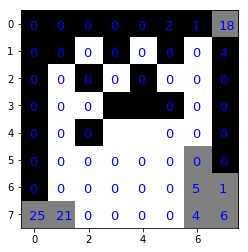

In [101]:
for i in range(len(moves)):
    if label2move[i] == 'PASS':
        continue
    p, q = label2move[i]
    plt.text(q-0.2, p+0.2, str(int(moves[i]*100)), color='blue', fontsize=13)
# end for
plt.imshow(-board, cmap=plt.gray());

* The network has not completely understood the game
    * Network mostly avoided filled positions (assigned probability of 0), but a few still was assigned low probabiliteis (e.g. (5, 0), (6, 1), (7, 1)).
    * Network still trying to make some illegal positions (e.g. (7, 6), (7, 7)
* The top predictions look correct though (e.g. (0, 7), (7, 0) for the corners and (1, 7) for eng-game points taking.

In [88]:
# legacy, please ignore
'''
def entropy(Ps, epsilon = 0.00001):
    Ps = Ps.detach().cpu().numpy()

    Ps = Ps + epsilon
    Ps = Ps / sum(Ps)
    return -np.dot(Ps, np.log(Ps))
# end def

import numpy as np
_ini = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
_ini = torch.from_numpy(np.array([_ini, _ini])).float()
_ini = _ini.to(device)

_mid = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 1, 0, 1, 0, -1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, -1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
_mid = torch.from_numpy(np.array([_mid, _mid])).float()
_mid = _mid.to(device)

            #msg = 'starter_prob: %4.3f' % (net(_ini)[0][-1]*2-1,)
            #print(msg)
            #fout.writelines(msg+'\n')            
            #msg = 'entropy: %4.3f, %4.3f' % (entropy(net(_ini)[0][:-1]), entropy(net(_mid)[0][:-1]),)
            #print(msg)
            #fout.writelines(msg+'\n')            

''';